# Assignment 5: Scene Recognition with Bag of Words

In [168]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt  
import seaborn as sn
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, silhouette_samples, silhouette_score
from tqdm import tqdm

## Question 4: bags of SIFT descriptors
### Question 4a: clustering SIFT descriptors with K-means 

In [183]:
def load(ds_path):
    """ Load from the training/testing dataset.

    Parameters
    ----------
    ds_path: path to the training/testing dataset.
             e.g., sift/train or sift/test 
    
    Returns
    -------
    image_paths: a (n_sample, 1) array that contains the paths to the descriptors. 
    labels: class labels corresponding to each image
    """
    # Grab a list of paths that matches the pathname
    files = glob.glob(os.path.join(ds_path, "*", "*.txt"))
    n_files = len(files)
    image_paths = np.asarray(files)
 
    # Get class labels
    classes = glob.glob(os.path.join(ds_path, "*"))
    labels = np.zeros(n_files)

    for i, path in enumerate(image_paths):
        folder, fn = os.path.split(path)
        labels[i] = np.argwhere(np.core.defchararray.equal(classes, folder))[0,0]

    # Randomize the order
    idx = np.random.choice(n_files, size=n_files, replace=False)
    image_paths = image_paths[idx]
    labels = labels[idx]
    return image_paths, labels

def sample_descriptors(image_paths):
    """ Sample SIFT descriptors, cluster them using k-means, and return the fitted k-means model.
    NOTE: We don't necessarily need to use the entire training dataset. You can use the function
    sample_images() to sample a subset of images, and pass them into this function.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    
    Returns
    -------
    descriptors: a (n_image * n_each, 128) array of sampled descriptors
    """
    n_image = len(image_paths)

    # Since want to sample tens of thousands of SIFT descriptors from different images, we
    # calculate the number of SIFT descriptors we need to sample from each image.
    n_each = int(np.ceil(10000 / n_image))

    # Initialize an array of features, which will store the sampled descriptors
    # keypoints = np.zeros((n_image * n_each, 2))
    descriptors = np.zeros((n_image * n_each, 128))

    for i, path in enumerate(image_paths):
        # Load features from each image
        features = np.loadtxt(path, delimiter=',',dtype=float)
        sift_keypoints = features[:, :2]
        sift_descriptors = features[:, 2:]
        
        # Randomly sample n_each descriptors from sift_descriptor and store them into descriptors
        n,d = sift_descriptors.shape
        indices = np.random.choice(n, n_each)
        descriptors[i:i+n_each,:] = sift_descriptors[indices]
    
    return descriptors
    
def build_vocabulary(descriptors):
    # Perfom k-means clustering to cluster sampled sift descriptors into vocab_size regions.
    print("Fitting K-means clustering")
    silhouette_scores = []
    for c in np.arange(10, 101, 10):
        kmeans = KMeans(n_clusters=c, random_state=0).fit(descriptors)
        labels = kmeans.predict(descriptors)
        
        # The silhouette_score gives the average value for all the samples
        # This gives a perspective into the density and separation of the formed clusters
        ss = silhouette_score(descriptors, labels)
        silhouette_scores.append(ss)
    
    plt.plot(np.arange(10, 101, 10), silhouette_scores)
    plt.ylabel('silhouette_score')
    plt.xlabel('n_clusters')
    plt.show()
    
    # Return fitted model with best clustering from silhouette score plot
    return KMeans(n_clusters=60, random_state=0).fit(descriptors)

In [179]:
print('Getting paths and labels for all train and test data')
train_image_paths, train_labels = load("sift/train")
test_image_paths, test_labels = load("sift/test")

print('Extracting SIFT features')
descriptors = sample_descriptors(train_image_paths)

0it [00:00, ?it/s]

Getting paths and labels for all train and test data
Extracting SIFT features


1500it [01:15, 20.00it/s]


Fitting K-means clustering


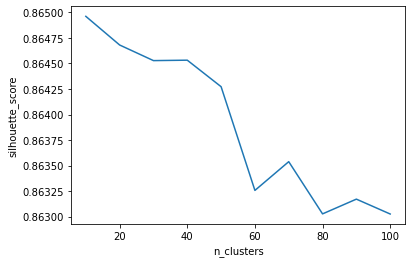

In [184]:
kmeans = build_vocabulary(descriptors)

Using the elbow method to find a suitable number of clusters, it is evident that 60 clusters is a good fit for our data. We can see the the silhouette score is rather high with less than 60 clusters, and hovers at around the same range with more than 60 clusters. In order to prevent the model from overfitting to the data, we use K-means with 60 clusters.

### Question 4b: representing images as bags of SIFT feature histograms

In [185]:
def get_bags_of_sifts(image_paths, kmeans):
    """ Represent each image as bags of SIFT features histogram.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    kmeans: k-means clustering model with vocab_size centroids.

    Returns
    -------
    image_feats: an (n_image, vocab_size) matrix, where each row is a histogram.
    """
    n_image = len(image_paths)
    vocab_size = kmeans.cluster_centers_.shape[0]
    image_feats = np.zeros((n_image, vocab_size))

    for i, path in enumerate(image_paths):
        # Load features from each image
        features = np.loadtxt(path, delimiter=',',dtype=float)

        # Assign each feature to the closest cluster center
        # Again, each feature consists of the (x, y) location and the 128-dimensional sift descriptor
        # You can access the sift descriptors part by features[:, 2:]
        sift_descriptors = features[:, 2:]
        predictions = kmeans.predict(sift_descriptors)

        # Build a histogram normalized by the number of descriptors
        hist, bins = np.histogram(predictions, bins=np.arange(vocab_size+1), density=True)
        image_feats[i,:] = hist
        
    return image_feats

In [186]:
train_image_feats = get_bags_of_sifts(train_image_paths, kmeans)
test_image_feats = get_bags_of_sifts(test_image_paths, kmeans)

### Question 4c: average histogram for each scene category
While most of the category histograms are distinct, there are some that are surprisingly alike. For example, categories 6 and 9 have a similar distribution, with similar values in similar bins. This is also true for categories 8 and 10, and categories 6 and 7. We can predict that the classifiers will not perform as well to differentiate between these pairs of classes. For example, the model may predict an image to belong to category 7 when it actually belongs to category 6.

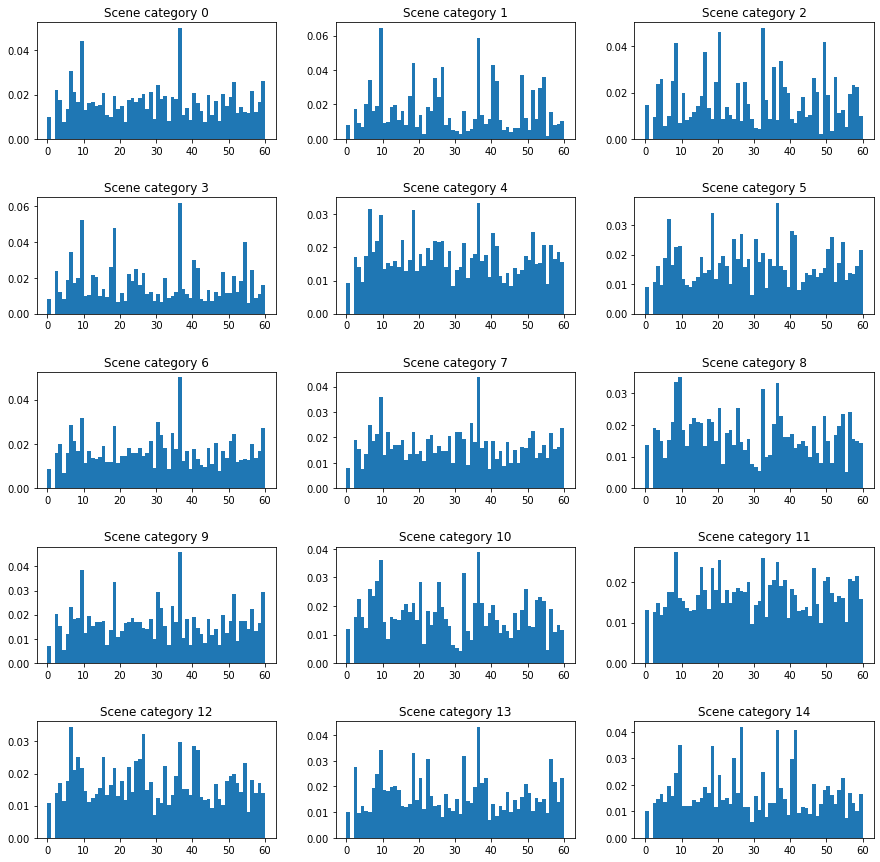

In [192]:
vocab_size = kmeans.cluster_centers_.shape[0]
category_feats = np.zeros((15, vocab_size))
bins = np.arange(vocab_size+1)

for row, label in zip(train_image_feats, train_labels):
    category_feats[int(label),:] = category_feats[int(label),:] + row

fig, axs = plt.subplots(5,3, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =0.5, wspace=0.25)
axs = axs.ravel()

for i, category in enumerate(category_feats):
    category_feats[i] = category / list(train_labels).count(i)
    axs[i].hist(bins[:-1], bins, weights=category_feats[i])
    axs[i].set_title("Scene category {}".format(i))

## Question 5: scene recognition with KNN

In [201]:
def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats):
    """ This function will predict the category for every test image by finding the 
    training image with most similar features. Instead of 1 nearest neighbor, you can 
    vote based on k nearest neighbors which will increase performance (although you need 
    to pick a reasonable value for k).
    
    Parameters
    ----------
    train_image_feats: is an N x d matrix, where d is the dimensionality of the feature representation.
    train_labels: is an N x l cell array, where each entry is a string
                  indicating the ground truth one-hot vector for each training image.
    test_image_feats: is an M x d matrix, where d is the dimensionality of the
                      feature representation. You can assume M = N unless you've modified the starter code.

    Returns
    -------
    is an M x l cell array, where each row is a one-hot vector
    indicating the predicted category for each test image.
    """
    # Keep track of best accuracy and model
    best_acc = (1,0)
    best_model = None
    accuracies = []
    
    # Fit KNN classifiers on range of n_neighbours
    for nn in range(1,30):
        model = KNeighborsClassifier(n_neighbors=nn).fit(train_image_feats, train_labels)
        predicted_labels = model.predict(test_image_feats)
        acc = model.score(test_image_feats, test_labels)
        
        # Save model if new acc is better than current best
        accuracies.append(acc)
        if acc > best_acc[1]:
            best_acc = (nn, acc)
            best_model = model
    
    plt.plot(range(1,30), accuracies)
    plt.ylabel('Accuracy')
    plt.xlabel('n_neighbours')
    plt.show()    
    
    print("Model with best test accuracy:")
    print("{} neighbours, {} accuracy".format(best_acc[0], best_acc[1]))
    
    print("Normalized confusion matrix (true labels vs. predicted labels):")
    cf_matrix = confusion_matrix(test_labels, best_model.predict(test_image_feats), labels=list(range(0,15)))
    cm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    sn.heatmap(cm)
    return predicted_labels

Using nearest neighbor classifier to predict test set categories


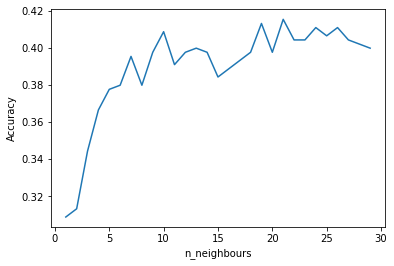

Model with best test accuracy:
21 neighbours, 0.41555555555555557 accuracy
Normalized confusion matrix (true labels vs. predicted labels):


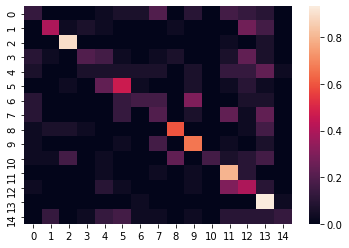

In [202]:
print('Using nearest neighbor classifier to predict test set categories')
pred_labels_knn = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)

From the plot above, we can see that there is a significant increase in accuracy when we increase the number of neighbours from 2 to 10. This improvement is due to the model being less prone to overfitting, since it uses more neighbours. The model performs decently with 10-20 neighbours, achieving the best accuracy with 21 neighbours. 

It is worth noting that there is little difference in accuracy between using 10 and 21 neighbours. If we prefer a more flexible model that can fit data with greater variance, we should use KNN with 10 neighbours. If we prefer a model more robust to noise in the data, we should use KNN with 21 neighbours.

From the confusion matrix, we can confirm our suspicions from before. When the true label is 6, there is a high chance the classifier predicts 9. When the true label is 10, there is a high chance the classifier predicts 8. There are also some surprising results, between true labels 1 and predicted labels 12. I am not sure why the classifier did so poorly differentiating these two classes, as their histograms (above) are rather different.

## Question 6: scene recognition with 1-vs-all linear SVMs

In [206]:
def svm_classify(train_image_feats, train_labels, test_image_feats):
    """ This function will train a linear SVM for every category (i.e. one vs all) and then use the 
    learned linear classifiers to predict the category of very test image. Every test feature will 
    be evaluated with all 15 SVMs and the most confident SVM will "win". Confidence, or distance 
    from the margin, is W*X + B where '*' is the inner product or dot product and W and B are the 
    learned hyperplane parameters. 
    
    Parameters
    ----------
    train_image_feats:  is an N x d matrix, where d is the dimensionality of the feature representation.
    train_labels: is an N x l cell array, where each entry is a string
                  indicating the ground truth one-hot vector for each training image.
    test_image_feats: is an M x d matrix, where d is the dimensionality of the
                      feature representation. You can assume M = N unless you've modified the starter code.

    Returns
    -------
    is an M x l cell array, where each row is a one-hot vector
    indicating the predicted category for each test image.
    """ 
    # Keep track of best accuracy and model
    best_acc = (0,0)
    best_model = None
    accuracies = []
    
    # Fit linear-SVM on range of regularization param. c
    for c in np.arange(3, 9, 0.25):
        model = LinearSVC(C=c).fit(train_image_feats, train_labels)
        predicted_labels = model.predict(test_image_feats)
        acc = model.score(test_image_feats, test_labels)
        
        # Save model if new acc is better than current best
        accuracies.append(acc)
        if acc > best_acc[1]:
            best_acc = (c, acc)
            best_model = model
            
    plt.plot(np.arange(3, 9, 0.25), accuracies)
    plt.ylabel('Accuracy')
    plt.xlabel('Regularization param. C')
    plt.show()    
    
    print("Model with best test accuracy:")
    print("C={}, {} accuracy".format(best_acc[0], best_acc[1]))
    
    print("Normalized confusion matrix (true labels vs. predicted labels):")
    cf_matrix = confusion_matrix(test_labels, best_model.predict(test_image_feats), labels=list(range(0,15)))
    cm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    sn.heatmap(cm)
    return predicted_labels

Using support vector machine to predict test set categories


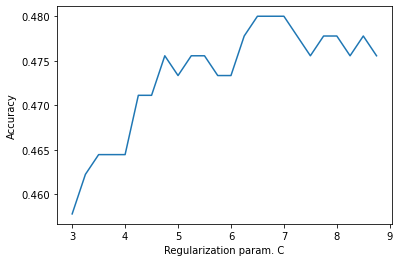

Model with best test accuracy:
C=6.5, 0.48 accuracy
Normalized confusion matrix (true labels vs. predicted labels):


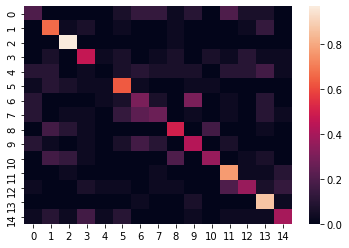

In [205]:
print('Using support vector machine to predict test set categories')
pred_labels_svm = svm_classify(train_image_feats, train_labels, test_image_feats)

From the plot above, we can see that performance of the classifier peaks when the regulurization parameter C equals 6.5. Regularization adjusts how robust the SVM is to variance in the data, where a low number results in a more flexible model, while a higher number results in a more robust model. 6.5 is a large number, so we can infer that our data has a significant amount of variance, and increasing the regularization parameter helps to prevent the model from overfitting. Increasing C past 6.5 results in a decrease in accuracy, suggesting that there is too much regularization, and the model is underfitting.

From the confusion matrix, we can see that this classifier does a much better job at separating and classifying the scenes than the KNN classifier. The model has trouble with categories 6 and 7, and 6 and 9, as we predicted from looking at the histograms above. It is also interesting to note that the classifier does very poorly on cateogry 4, having nearly no correct predictions. On the otherhand, the classifier correctly predicts nearly all of the scenes in category 2.